# Graphs and Linear Algebra

## Table of Contents <a name="toc"></a>

0. [Table of Contents](#toc)
1. [Introduction](#introduction)
2. [What is a graph?](#what-is-a-graph)
    1. [Converting non-graph data into graphs](#converting)
3. [Special matrices for graphs](#matrices)
    1. [Adjacency Matric](#adjacency)
    2. [Degree Matrix](#degree)
    3. [Incidence Matrix](#incidence)
    4. [Combinatorial Graph Laplacian](#com-laplacian)
    5. [Symmetric Normalized Graph Laplacian](#sym-laplacian)
4. [The Graph Laplacian: a spectral representation of graphs](#laplacian)
    1. [A quick review of eigens](#eigens)
    2. [Manifold interpretation](#manifold)
    3. [An application: spectral clustering](#spectral-clustering)
5. [Conclusion](#conclusion)
5. [References](#references)

## Introduction <a name="introduction"></a>

This page is the first of several to introduce the mathematical structure called *graphs*, or *networks*. Graphs--due to their versatillity and ability to generalize easily--are used in many fields, from modeling the brain, to social media connections, to traffic. Here, we discuss how to represent graphs using linear algebra.

For this series, we will use [PyGSP](https://pygsp.readthedocs.io/en/latest/index.html), a graphical signal processing library, to create and display graphs (Note that much of the functionallity appears to be different than the documentation). Additionally, [SymPy](https://docs.sympy.org/latest/tutorials/intro-tutorial/preliminaries.html#installation) will be used to display formatted matrices automatically. [Sklearn](https://scikit-learn.org/stable/install.html) is used for generating datasets and applying k-means.

```python
import matplotlib.pyplot as plt
import numpy as np
from pygsp import graphs, plotting
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
from sklearn.neighbors import radius_neighbors_graph
from sympy import *

init_printing(use_unicode=True)
```

## What is a graph? <a name="what-is-a-graph"></a>

Graphs--in the simplest manner--represent complex connections between elements. This could be the connection between two neurons, if two people are friends on instagram, or the connection by way of roads of two intersections. These elements are called *nodes*, or *vertices*, while the connection between them are called *edges*. Additionally these edges could be *weighted*, such as the degree of synaptic coupling between neurons, or the number of miles a road is between intersections. Furthermore, the edges can either by *directed*, in which information can only flow one way, or *undirected* if otherwise.

More formally, a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ can be represented by a set of nodes $\mathcal{V}$ and set of edges between nodes $\mathcal{E}$. If weighted, a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E}, W)$ is further represented by its adjacency matrix $W \in \mathbb{R}^{N \times N}$, where $N = |\mathcal{V}|$ is the number of nodes. [1]

We begin this tutorial with a simple example: we will use PyGSP to randomly generate a network of sensors. The sensors are represented below by the colored nodes, while the edges between them measure some distance or connection between sensors. 

```python
# define parameters
N = 16

# instantiate graph that models sensor network
G = graphs.Sensor(N=N, seed=42)
        
# plot graph
G.plot_signal(G.U[:, 1])
```

<img src="./docs/assets/img/graphs/network.png" alt="network" width="500"/>

### Converting non-graph data into graphs <a name="converting"></a>

The input data you work with does not necessarily have to start as a graph in order to process it as one. Several methods exist to convert data points into nodes of a graph [2]:

1. **$\epsilon$-neighbor graph**: Create an unweighted graph between points, where two nodes $x_i$ and $x_j$ are connected if $d(x_i, x_j) < \epsilon_d$, or $s(x_i, x_j) > \epsilon_s$.

2. **k-nearest neighbor graph**: First, create a directed graph between points by finding their k-nearest and setting their weights to whatever similarity measure/distance metric was used. An undirected graph can then be constructed by either keeping an edge between nodes if there exists at least one directed edge between them, or alternatively if there exists a mutual directed edge between the two nodes going both ways.

3. **Fully connected graph**: Simply use a pairwise similarity measure to construct a fully connected graph. One common measure is the Gaussian kernel $s(x_i, x_j) = \exp(-\dfrac{||x_i - x_j||^2}{2 \sigma^2})$. This is often paried with the $\epsilon$-neighbor graph to reduce the number of edges.

## Special matrices for graphs <a name="matrices"></a>

### Adjacency Matrix <a name="adjacency"></a>

The most critical matrix representation of any graph is its adjacency matrix $W \in \mathbb{R}^{N \times N}$, which dictates the connections between nodes. Assuming a graph is weighted, a connection between two nodes $v_i, v_j \in \mathcal{V}$ are given by the matrix element $w_{ij} \in W$, where $w_{ij}$ is zero if no connection is present, and the non-zero value of the weighted edge otherwise. If a graph is unweighted, $w_{ij} = 1$ when a connection is present. Note that for undirected graphs, $W$ is symmetric, or in other words, $w_{ij} = w_{ji}$ for all $i$ and $j$. [2]

```python
# instantiate adjacency matrix W
W = np.zeros((N, N))

# assign weights to matrix
for i in range(N) :
    for j in range(N) :
        W[i, j] = G.W[i, j]
        
# round to 3 s.f.
W = np.around(W, 3)
```

Below shows the matrix output of the graph we generated earlier. Note the symmetric property of the matrix.

<img src="./docs/assets/img/graphs/adjacency.png" alt="adjacency" width="500"/>

### Degree Matrix <a name="degree"></a>

The degree matrix may seem like it carries less information than the adjacency matrix, but we will see shortly why it is so important. The degree matrix tells us the number of connections from a given node. More formally, $d_{ii} = \sum_{j=1}^N w_{ij}$. Note that the matrix is diagonal. If the graph is unweighted, the entree at $d_{ii}$ is simply the number of connections. [2]

```python
# instantiate degree matrix D
D = np.zeros((N, N))

# construct diagonal D
for i in range(N) :
    D[i, i] = np.sum(W[i, :])
        
# round to 3 s.f.
D = np.around(D, 3)
```

Note that the below matrix is non-zero only along its diagonal.

<img src="./docs/assets/img/graphs/diagonal.png" alt="degree" width="400"/>

### Incidence Matrix <a name="incidence"></a>

Simply stated, the incidence matrix tells us the ingoing and outgoing edges from a node, with the rows representing a node and columns representing an edge. An entry is $\sqrt{w_{ij}}$ if outgoing, $-\sqrt{w_{ij}}$ if ingoing, and $0$ if no edge is present. We will not spend too much time discussing this matrix, as we generally assume our graphs to be undirected, but it is necessary to discuss before introducing the following two matrices. 

### Combinatorial Graph Laplacian <a name="com-laplacian"></a>

From the incidence matrix $M \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{E}|}$, constructing the graph Laplacian $L \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ is simply $L = M M^T$. Interestingly, this is equivalent to $L = D - W$, which is how we generally construct it. Note that this graph Laplacian, otherwise known as the combinatorial graph Laplacian, holds information about 3 seperate matrices used to describe the graph $\mathcal{G}$. [2]

```python
# compute combinatorial graph Laplacian
L_combinatorial = D - W
```

Additionally, the combinatorial graph Laplacian has the following properties:

1. $\forall f \in \mathbb{R}^N$, the following holds true: $f^T L f = \dfrac{1}{2} \sum_{i,j=1}^N w_{ij} (f_i - f_j)^2$
2. $L$ is symmetric and positive semi-definite
3. The smallest eigenvalue of $L$ is $0$, and the corresponding eigenvector is the vector of all ones
4. $L$ has $N$ non-negative, real-valued eigenvalues such that $0 = \lambda_1 \leq \lambda_2 \leq ... \leq \lambda_N$

Note that the diagonals are the entries to $D$ and the non-diagonals are the negative entries of $W$.

<img src="./docs/assets/img/graphs/laplacian_com.png" alt="laplacian_com" width="500"/>

### Symmetric Normalized Graph Laplacian <a name="sym-laplacian"></a>

The normalized graph Laplacian has several definitions, but we will go with the one presented in [3], which differs from the one in [2] in only that the eigenvalues in one are equal to one minus the eigenvalues in the other. The symmetric normalized graph Laplacian is constructed as follows: $L = D^{-1/2} W D^{-1/2}$.

```python
# compute symmetrical graph Laplacian
L_symmetrical = np.diag(G.d ** (-1/2)) @ W @ np.diag(G.d ** (-1/2))

# round to 3 s.f.
L_symmetrical = np.around(L_symmetrical, 3)
```

Properties 2 and 4 still holds from the combinatorial graph Laplacian, with 1 and 3 having the following modifications:

1. $\forall f \in \mathbb{R}^N$, the following holds true: $f^T L f = \dfrac{1}{2} \sum_{i,j=1}^N w_{ij} (\dfrac{f_i}{\sqrt{d_i}} - \dfrac{f_j}{\sqrt{d_j}})^2$
3. The smallest eigenvalue of $L$ is $0$, and the corresponding eigenvector is the vector of all ones times $D^{-1/2}$

The Laplacian matrix is shown below, note the differences between it and the previous Laplacian:

<img src="./docs/assets/img/graphs/laplacian_sym.png" alt="laplacian_sym" width="500"/>

## The Graph Laplacian: a spectral representation of graphs <a name="laplacian"></a>

### A quick review of eigens <a name="eigens"></a>

In a linear space, an operator (or matrix) $T \in \mathbb{R}^{N \times N}$ can do two things to a vector: rotate and scale it. To retrieve the eigenvalues and eigenvectors of an operator $T$, one only needs to solve the equation $T u = \lambda u$ (or, equivalently $(T - \lambda I) u = 0$), where $\lambda \in \mathbb{R}$ is the non-zero scalar eigenvalue and $u \in \mathbb{R}^{N}$ is the corresponding eigenvector [4]. Essentially what this can be interpreted as is finding a vector that, when the operator is applied to said vector, simply scales the vector instead of rotating it.

Eigens are useful for characterizing an operator, and serve a similar function to finding the roots of a polynomial. For example, the eigenvector with the maximum eigenvalue is the vector in the entire vector space with the maximum scaling. Another useful property is the fact that eigenvectors are orthogonal to one another, making them useful basis. This fact allows eigenvectors to serve a central function in Principal Component Analysis (PCA). Essentially, the eigenvectors of the covaraince matrix of a given dataset gives the principal components of said dataset. These principal components are used to give the axis with maximum and minimum variance. This fact is likewise used in the Karhunen-Loeve Tranform (KLT), where eigenvectors serve a similar fiunction.

```python
# generate affine data projection
x1 = np.linspace(0, 5, 1000)
x2 = 3.2 * x1 + 0.5

# add noise to data set
y = x2 + np.random.normal(0, 3, 1000)

# covariance of data
Cov = np.cov(np.vstack((x1, y)))

# PCA
w, v = np.linalg.eigh(Cov)

# means of data
mu1 = np.mean(x1)
mu2 = np.mean(x2)

# plot PCA
plt.scatter(x1, y, c='c', label='observed data')
plt.quiver(mu1, mu2, w[1]*v[1, 1], w[1]*v[0, 1], scale=75, color='b', label='PC1')
plt.quiver(mu1, mu2, w[0]*v[1, 0], w[0]*v[0, 0], scale=5, color='r', label='PC2')
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
```

<img src="./docs/assets/img/graphs/pca.png" alt="pca" width="500"/>

With this in mind, we can use the eigendocomposition (that is, the retrieval of all eigenvalues and corresponding eigenvectors) of the graph Laplacian $L$ to give us important information about the underlying structure of our graph.

### Manifold interpretation <a name="manifold"></a>

By taking the eigenvectors of $L$, we are effectively creating a manifold of our graph data in Euclidean space. We will take a look at the *Minnesota Road Network* dataset, modeled by a large graph with nodes that have time-varying values.

<img src="./docs/assets/img/graphs/minnesota.png" alt="minnesota" width="500"/>

As before, we construct $L$ from $W$ and $D$. We then take the eigendecomposition of $L$ to get us the spectral components of $\mathcal{G}$. By taking the first 3 eigenvectors, we can visualize the spectral manifold in a 3D space.

```python
# instantiate graph that models Minnesota road network
G = graphs.Minnesota()

# define parameters
N = G.N
W = np.zeros((N, N))
D = np.zeros((N, N))

# assign weights to matrix
for i in range(N) :
    for j in range(N) :
        W[i, j] = G.W[i, j]

# construct diagonal D
for i in range(N) :
    D[i, i] = np.sum(W[i, :])
    
# compute combinatorial graph Laplacian
L_combinatorial = D - W

# eigen decomposition
w, v = np.linalg.eigh(L_combinatorial)

# 3D manifold
manifold = v[:, :3]
```

<img src="./docs/assets/img/graphs/manifold.png" alt="manifold" width="500"/>

Interestingly, this process bares striking reseblance to a widely used manifold learning algorithm, kernel PCA [3]. Kernel PCA is similar to PCA, but instead of using the eigenvectors of the covariance matrix for the principal components, uses the eigenvectors of a kernel matrix $K$ constructed from the input data. We will not go into detail on kernel methods here, but essentially the graph Laplacian $L$ is equivalent to constructing the kernel matrix $K$.

### An application: spectral clustering <a name="spectral-clusetering"></a>

Clustering is a non-supervised method to partition dataset into groups of similarity. Spectral clustering has several advantages over traditional clustering methods: it can cluster non-linearly seperable groups, and it can cluster on graphs. [We have stated above](#manifold) that the spectral manifold of the graph $\mathcal{G}$ allows a mapping to a manifold in which traditional Euclidean distance measures can be applied. Not only does this allow traditional clustering methods like k-means to be applied to graph data, but it also means difficult non-graph data (such as non-linearly seperable clusters) can be [mapped to graphs](converting), and the same methods can then be applied. It is worth mentioning that there are alternative methods to clustering on graphs, such as mimumum cut algorithms, but these are NP-hard, making spectral clustering an appetizing alternative [2]. Below is a spectral clustering algorithm presented in [3], where given are the adjacenecy and degree matrices $W, D \in \mathbb{R}^{N \times N}$ and the clusters $k$:

1. Compute symmetric normalized graph Laplacian $L = D^{-1/2} W D^{-1/2}$

2. Find the first $k$ largest eigenvectors $x_1, x_2, ..., x_k$ of $L$ and form $X = [x_1 x_2 ... x_k]$

3. Normalize the eigenvectors $Y_{ij} = \dfrac{X_{ij}}{\sqrt{\sum_j X_{ij}^2}}$

4. Perform k-means on $Y$ as data points in $\mathbb{R}^k$, returning the cluster membership of each of the $N$ nodes

To demonstrate, we will implement the spectral clustering algorithm on a test dataset. The "circles" dataset is chosen because, as demonstrated below, k-means is not able to distinguish the clusters.

```python
# parameters
k = 2
N = 500

# construct data
X, y = make_circles(n_samples=N, factor=0.5, noise=0.05)

#display results
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Circles')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# perform clustering directly on data
kmeans_direct = KMeans(n_clusters=k).fit(X)

# display results
plt.scatter(X[:, 0], X[:, 1], c=kmeans_direct.labels_, cmap='viridis')
plt.title('Direct K-Means Result')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
```

<img src="./docs/assets/img/graphs/circles.png" alt="circles" width="500"/>

<img src="./docs/assets/img/graphs/kmeans.png" alt="kmeans" width="500"/>

In order to perform spectal clustering on this dataset, we first must convert it into a graph. A modified version of the k-nearest neighbors is used, where all points within a specified radius have their weights computed. The algorithm is then applied as specified above.

```python
# create graph representation from input data
W = radius_neighbors_graph(X, 0.35, p=2,
                           mode='distance',
                           metric='minkowski',
                           metric_params=None,
                           include_self=False).toarray()
    
# construct degree matrix
D = np.zeros(N)
for i in range(N) :
    D[i] = np.sum(W[i, :])
    
# construct symmetric normalized graph Laplacian
L = np.diag(D ** (-1/2)) @ W @ np.diag(D ** (-1/2))

# eigen decomposition
w, v = np.linalg.eigh(L)

# sort eigens
sorted_indices = np.argsort(w)
w = np.real(w[sorted_indices])
v = np.real(v[:, sorted_indices.squeeze()])

# get first k eigenvectors
unnormalzied_Y = v[:, -k:]

# normalize 
Y = np.zeros((N, k))
for i in range(N) :
    normalize_factor = np.linalg.norm(unnormalzied_Y[i, :])
    if (normalize_factor != 0) :
        Y[i, :] = unnormalzied_Y[i, :] / np.linalg.norm(unnormalzied_Y[i, :])
    else :
        Y[i, :] = unnormalzied_Y[i, :]

# display 2D manifold
plt.scatter(Y[:, 0], Y[:, 1])
plt.title('2D Manifold')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# perform clustering
kmeans_spectral = KMeans(n_clusters=k).fit(Y)

# display results
plt.scatter(X[:, 0], X[:, 1], c=kmeans_spectral.labels_, cmap='viridis')
plt.title('Spectral K-Means Result')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
```

The top plot below shows the resulting spectral manifold after applying the graph Laplacian and projecting to a 2-dimensional space (which corresponds to the cluster count). The seperation of clusters relies mainly on the conversion of the data to its graph form. There is otherwise no hyperparameter tuning necessary to find an optimal performance of the algorithm. The bottom plot shows the resulting clustering after applying k-means to the spectral manifold.

<img src="./docs/assets/img/graphs/circles_manifold.png" alt="circles_manifold" width="500"/>

<img src="./docs/assets/img/graphs/spectral.png" alt="spectral" width="500"/>

## Conclusion <a name="conclusion"></a>

In this page, we have presented the basic formulation of the mathematical structure known as graphs. We have shown how they can be represented using several different matrices, namely the adjacent and degree matrices. These can then be used to construct the graph Laplacian matrix, whose eigenvectors holds spectral information of the graph's underlying structure. This fact allows us to formulate several useful algorithms, one of which--spectral clustering--is discussed. 

## References <a name="references"></a>

[1] Shuman, David I., et al. "The emerging field of signal processing on graphs: Extending high-dimensional data analysis to networks and other irregular domains." IEEE signal processing magazine 30.3 (2013): 83-98.

[2] Von Luxburg, Ulrike. "A tutorial on spectral clustering." Statistics and computing 17.4 (2007): 395-416.

[3] Ng, Andrew, Michael Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." Advances in neural information processing systems 14 (2001).

[4] Axler, Sheldon. Linear algebra done right. Springer Science & Business Media, 1997.

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from pygsp import graphs, plotting
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
from sklearn.neighbors import radius_neighbors_graph
from sympy import *

init_printing(use_unicode=True)

2022-12-23 17:08:09,792:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


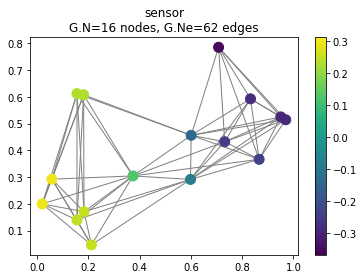

In [2]:
# define parameters
N = 16
W = np.zeros((N, N))
D = np.zeros((N, N))

# instantiate graph that models sensor network
G = graphs.Sensor(N=N, seed=42)

# assign weights to matrix
for i in range(N) :
    for j in range(N) :
        W[i, j] = G.W[i, j]

# construct diagonal D
for i in range(N) :
    D[i, i] = np.sum(W[i, :])
    
# round to 3 s.f.
W = np.around(W, 3)
D = np.around(D, 3)
        
# plot graph
G.plot_signal(G.U[:, 1])

In [3]:
Matrix(W)

⎡ 0.0    0.0   0.745  0.451  0.748  0.858  0.815  0.605  0.859   0.0   0.757  
⎢                                                                             
⎢ 0.0    0.0   0.891  0.694   0.0    0.0    0.0   0.468  0.772  0.772   0.0   
⎢                                                                             
⎢0.745  0.891   0.0   0.463   0.0    0.0    0.0   0.955  0.964  0.774   0.0   
⎢                                                                             
⎢0.451  0.694  0.463   0.0    0.0   0.639   0.0   0.854  0.946   0.0    0.0   
⎢                                                                             
⎢0.748   0.0    0.0    0.0    0.0   0.634  0.398   0.0   0.635   0.0   0.681  
⎢                                                                             
⎢0.858   0.0    0.0   0.639  0.634   0.0   0.935   0.0    0.0    0.0   0.478  
⎢                                                                             
⎢0.815   0.0    0.0    0.0   0.398  0.935   0.0    0

In [4]:
Matrix(D)

⎡7.881   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0   5.559   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0    0.0   6.601   0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0    0.0    0.0   6.807   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0    0.0    0.0    0.0   4.764   0.0    0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0    0.0    0.0    0.0    0.0   6.155   0.0    0.0    0.0    0.0   0.0   0
⎢                                                                             
⎢ 0.0    0.0    0.0    0.0    0.0    0.0   4.835   0

In [5]:
# compute combinatorial graph Laplacian
L_combinatorial = D - W

# compute symmetrical graph Laplacian
L_symmetrical = np.diag(G.d ** (-1/2)) @ W @ np.diag(G.d ** (-1/2))

# round to 3 s.f.
L_symmetrical = np.around(L_symmetrical, 3)

In [6]:
Matrix(L_combinatorial)

⎡7.881    0.0    -0.745  -0.451  -0.748  -0.858  -0.815  -0.605  -0.859   0.0 
⎢                                                                             
⎢ 0.0    5.559   -0.891  -0.694   0.0     0.0     0.0    -0.468  -0.772  -0.77
⎢                                                                             
⎢-0.745  -0.891  6.601   -0.463   0.0     0.0     0.0    -0.955  -0.964  -0.77
⎢                                                                             
⎢-0.451  -0.694  -0.463  6.807    0.0    -0.639   0.0    -0.854  -0.946   0.0 
⎢                                                                             
⎢-0.748   0.0     0.0     0.0    4.764   -0.634  -0.398   0.0    -0.635   0.0 
⎢                                                                             
⎢-0.858   0.0     0.0    -0.639  -0.634  6.155   -0.935   0.0     0.0     0.0 
⎢                                                                             
⎢-0.815   0.0     0.0     0.0    -0.398  -0.935  4.8

In [7]:
Matrix(L_symmetrical)

⎡ 0.0    0.0   0.079  0.043  0.085  0.091  0.093  0.064  0.082   0.0   0.086  
⎢                                                                             
⎢ 0.0    0.0   0.119  0.083   0.0    0.0    0.0   0.063  0.092  0.119   0.0   
⎢                                                                             
⎢0.079  0.119   0.0   0.052   0.0    0.0    0.0   0.119  0.108  0.112   0.0   
⎢                                                                             
⎢0.043  0.083  0.052   0.0    0.0   0.071   0.0   0.095  0.095   0.0    0.0   
⎢                                                                             
⎢0.085   0.0    0.0    0.0    0.0   0.085  0.057   0.0   0.076   0.0   0.097  
⎢                                                                             
⎢0.091   0.0    0.0   0.071  0.085   0.0   0.125   0.0    0.0    0.0   0.064  
⎢                                                                             
⎢0.093   0.0    0.0    0.0   0.057  0.125   0.0    0

In [8]:
# eigen decomposition
w, v = np.linalg.eigh(L_combinatorial)

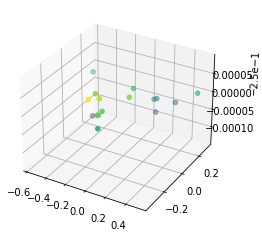

In [9]:
# display results
ax = plt.axes(projection='3d')
ax.scatter3D(v[:, 2], v[:, 1], v[:, 0], c=v[:, 0])

2022-12-23 17:08:28,619:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


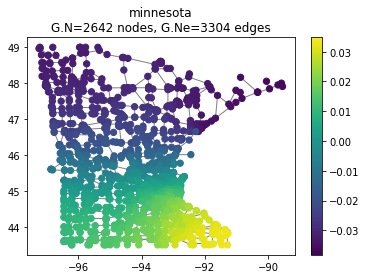

In [10]:
# instantiate graph that models sensor network
G = graphs.Minnesota()

# define parameters
N = G.N
W = np.zeros((N, N))
D = np.zeros((N, N))

# assign weights to matrix
for i in range(N) :
    for j in range(N) :
        W[i, j] = G.W[i, j]

# construct diagonal D
for i in range(N) :
    D[i, i] = np.sum(W[i, :])
    
# round to 3 s.f.
W = np.around(W, 3)
D = np.around(D, 3)
        
# plot graph
G.plot_signal(G.U[:, 1])

In [11]:
# compute combinatorial graph Laplacian
L_combinatorial = D - W

# compute symmetrical graph Laplacian
L_symmetrical = np.diag(G.d ** (-1/2)) @ W @ np.diag(G.d ** (-1/2))

# eigen decomposition
w, v = np.linalg.eigh(L_combinatorial)

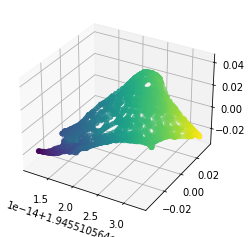

In [12]:
# display results
ax = plt.axes(projection='3d')
ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], c=v[:, 0])
plt.show()

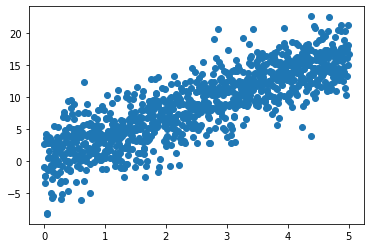

In [13]:
# generate affine data projection
x1 = np.linspace(0, 5, 1000)
x2 = 3.2 * x1 + 0.5

# add noise to data set
y = x2 + np.random.normal(0, 3, 1000)

# plot data
plt.scatter(x1, y)
plt.show()

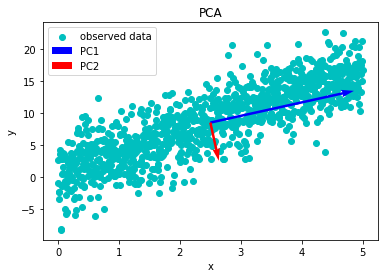

In [14]:
# covariance of data
Cov = np.cov(np.vstack((x1, y)))

# PCA
w, v = np.linalg.eigh(Cov)

# means of data
mu1 = np.mean(x1)
mu2 = np.mean(x2)

# plot PCA
plt.scatter(x1, y, c='c', label='observed data')
plt.quiver(mu1, mu2, w[1]*v[1, 1], w[1]*v[0, 1], scale=75, color='b', label='PC1')
plt.quiver(mu1, mu2, w[0]*v[1, 0], w[0]*v[0, 0], scale=5, color='r', label='PC2')
plt.title('PCA')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

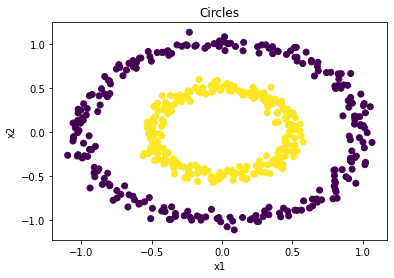

In [15]:
# parameters
k = 2
N = 500

# construct data
X, y = make_circles(n_samples=N, factor=0.5, noise=0.05)

#display results
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Circles')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

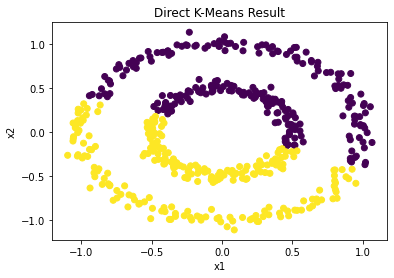

In [16]:
# perform clustering directly on data
kmeans_direct = KMeans(n_clusters=k).fit(X)

# display results
plt.scatter(X[:, 0], X[:, 1], c=kmeans_direct.labels_, cmap='viridis')
plt.title('Direct K-Means Result')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

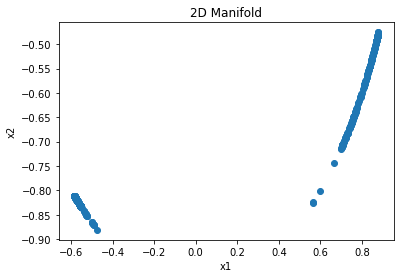

In [32]:
# create graph representation from input data
W = radius_neighbors_graph(X, 0.35, p=2,
                           mode='distance',
                           metric='minkowski',
                           metric_params=None,
                           include_self=False).toarray()
    
# construct degree matrix
D = np.zeros(N)
for i in range(N) :
    D[i] = np.sum(W[i, :])
    
# construct symmetric normalized graph Laplacian
L = np.diag(D ** (-1/2)) @ W @ np.diag(D ** (-1/2))

# eigen decomposition
w, v = np.linalg.eigh(L)

# sort eigens
sorted_indices = np.argsort(w)
w = np.real(w[sorted_indices])
v = np.real(v[:, sorted_indices.squeeze()])

# get first k eigenvectors
unnormalzied_Y = v[:, -k:]

# normalize 
Y = np.zeros((N, k))
for i in range(N) :
    normalize_factor = np.linalg.norm(unnormalzied_Y[i, :])
    if (normalize_factor != 0) :
        Y[i, :] = unnormalzied_Y[i, :] / np.linalg.norm(unnormalzied_Y[i, :])
    else :
        Y[i, :] = unnormalzied_Y[i, :]

# display 2D manifold
plt.scatter(Y[:, 0], Y[:, 1])
plt.title('2D Manifold')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

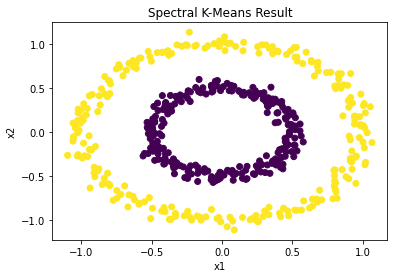

In [33]:
# perform clustering
kmeans_spectral = KMeans(n_clusters=k).fit(Y)

# display results
plt.scatter(X[:, 0], X[:, 1], c=kmeans_spectral.labels_, cmap='viridis')
plt.title('Spectral K-Means Result')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()